# Deep Sets
We use encoder-decoder architecture for neural networks trained on *permutation invariant* set-input data.
https://proceedings.neurips.cc/paper_files/paper/2017/file/f22e4747da1aa27e363d86d40ff442fe-Paper.pdf

In [3]:
import pandas as pd
import numpy as np
from ast import literal_eval
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import EarlyStopping
import keras.layers as L
import keras.backend as K
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
%load_ext blackcellmagic
NUM_CLASSES = 20 # to_categorical maps to 0,...,NUM_CLASSES-1
MIN_VERTICES, MAX_VERTICES = 4, 14
input_shape = (3, MAX_VERTICES)

# Data
df = pd.read_csv("../data/Pic4319.csv", converters={"matrix":lambda s: np.array(literal_eval(s))}, header=None, names=["matrix", "pic"])
df["pad"] = df["matrix"].apply(lambda mat: np.pad(mat, ((0, 0), (0, MAX_VERTICES - mat.shape[1]))))
X, y = df["pad"], df["pic"]
X, y = np.stack(X), keras.utils.to_categorical(y, num_classes=NUM_CLASSES)

2023-06-08 23:07:59.056022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
class PlotLearning(keras.callbacks.Callback):
    """Callback to plot the learning curves of the model during training."""

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if "val" not in x]
        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))
        clear_output(wait=True)
        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), self.metrics[metric], label=metric)
            if logs["val_" + metric]:
                axs[i].plot(
                    range(1, epoch + 2),
                    self.metrics["val_" + metric],
                    label="val_" + metric,
                )
            axs[i].legend()
            axs[i].grid()
        plt.tight_layout()
        plt.show()


def width_acc(y_true, y_pred, width=1):
    diff = K.abs(K.argmax(y_pred, axis=-1) - K.argmax(y_true, axis=-1))
    res = tf.math.count_nonzero(K.less_equal(diff, width))
    return int(res) / int(tf.shape(y_pred)[0])


def deepset_model(encoder_units=[64], decoder_units=[64], lr=1e-2, decay=1e-4):
    optimizer = Adam(learning_rate=lr, decay=decay)
    metrics = ["accuracy", width_acc]

    def mlp_encoder(encoder_units):
        
        # Encoder MLP phi
        inputs = L.Input(shape=(3,))
        v = inputs
        for units in encoder_units:
            v = L.Dense(units=units, activation="relu")(v)
            v = L.Dropout(0.25)(v)
        outputs = L.Reshape(v.shape[1:] + (1,))(v)
        return Model(inputs, outputs)

    encoder = mlp_encoder(encoder_units)
    inputs = L.Input(shape=(3, MAX_VERTICES))
    inputs_list = tf.unstack(inputs, axis=-1)
    encoded = list(map(encoder, inputs_list))
    x = L.Concatenate()(encoded)
    # Decoder Pooling and MLP rho
    x = L.GlobalAveragePooling1D(data_format="channels_first", name="pooling")(x)
    for units in decoder_units:
        x = L.Dense(units=units, activation="relu")(x)
        x = L.Dropout(0.25)(x)

    # Classifier
    outputs = L.Dense(NUM_CLASSES, activation="softmax")(x)

    # Model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics)
    print(model.summary())
    return model


def train_model(model, data, batch_size=32, epochs=500):
    X_train, X_test, y_train, y_test = data
    callbacks_list = [
        PlotLearning(),
        EarlyStopping(monitor="val_loss", patience=100, verbose=1),
    ]
    hist = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        shuffle=True,
        callbacks=callbacks_list,
    )

    return model, hist.history

def plot_confusion(X_test, y_test):
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    conf_mat = confusion_matrix(y_true, y_pred, labels=range(1, NUM_CLASSES))
    disp = ConfusionMatrixDisplay(conf_mat, display_labels=range(1, NUM_CLASSES))
    fig, ax = plt.subplots(figsize=(10,10)) 
    disp.plot(ax=ax, colorbar=False)
    plt.show()

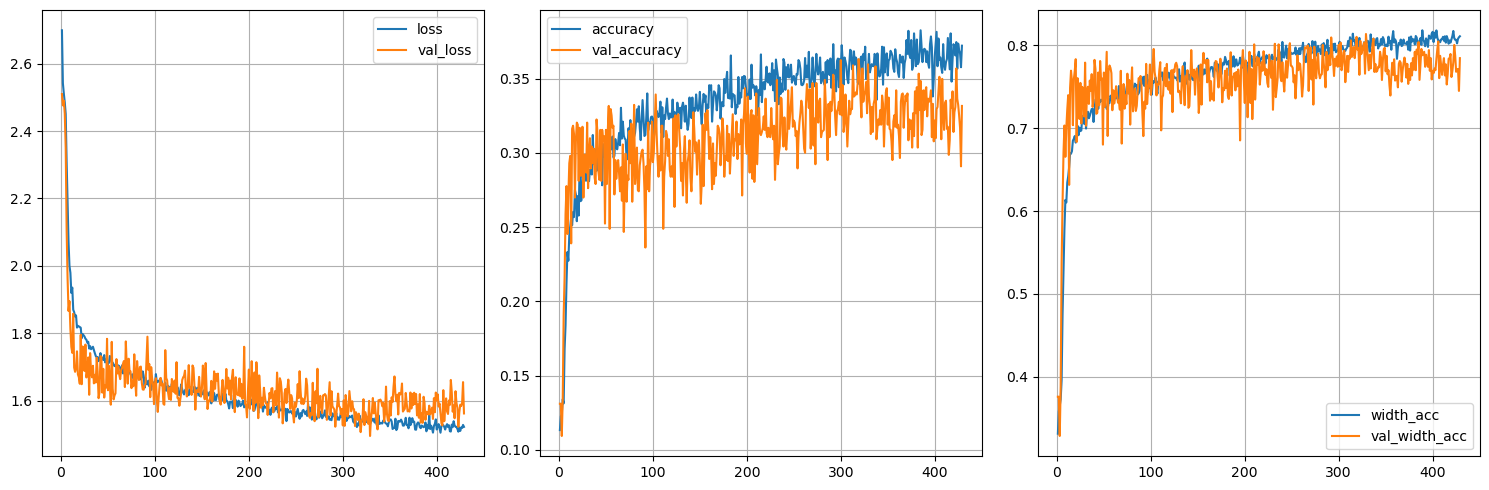

91/91 [==============================] - 1s 11ms/step - loss: 1.5221 - accuracy: 0.3723 - width_acc: 0.8111 - val_loss: 1.5620 - val_accuracy: 0.3317 - val_width_acc: 0.7847
Epoch 429: early stopping


In [18]:
batch_size, epochs = 32, 600
lr, decay = 1e-3, 1e-4
data = X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=None)
model = deepset_model(encoder_units=[64, 64, 64], decoder_units=[64, 64, 64], lr=lr, decay=decay)
model, history = train_model(model, data)

45/45 [==============================] - 0s 1ms/step


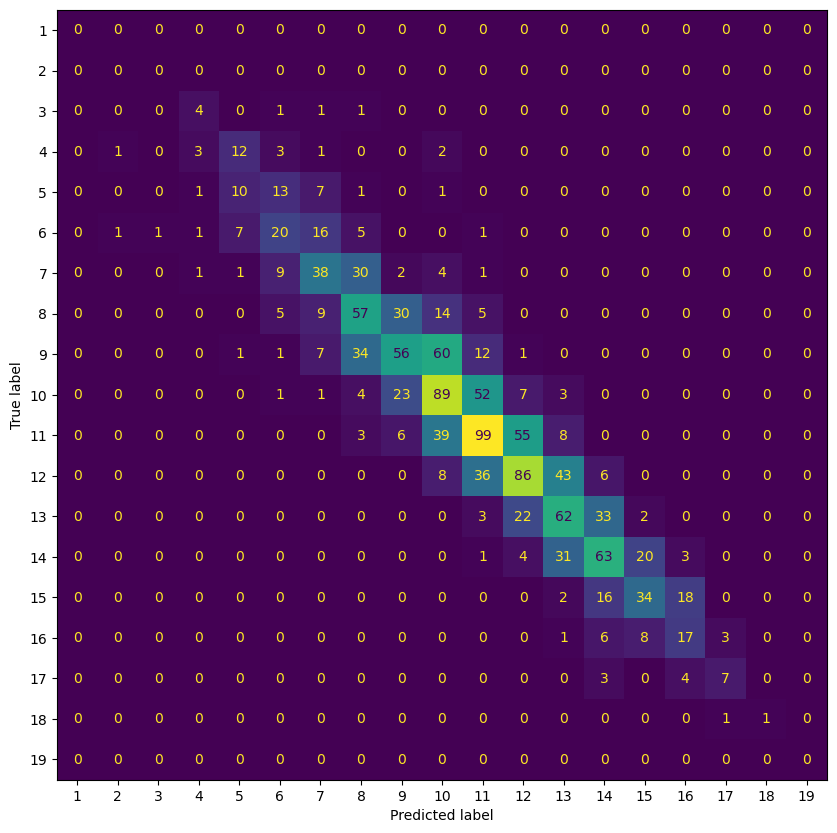

In [12]:
plot_confusion(X_test, y_test)